In [13]:
import requests
import json
import sys
import os
import io
from PIL import Image, ImageFilter
from google.cloud import storage
from io import BytesIO
import time
import threading
import random

In [2]:
import yaml

# Load the YAML file
with open('../cf/.env.yaml', 'r') as file:
    env_vars = yaml.safe_load(file)

# Retrieve the values of SDAPI_KEY and CLIPDROP_KEY
SDAPI_KEY = env_vars.get('SDAPI_KEY')
CLIPDROP_KEY = env_vars.get('CLIPDROP_KEY')


{
    "status": "success",
    "generationTime": 9.3,
    "id": 63241937,
    "output": [
        "https://pub-3626123a908346a7a8be8d9295f44e26.r2.dev/generations/0-049ab281-f9c6-42ed-87b7-f4816f55c6b8.png"
    ],
    "meta": {
        "prompt": " a predator alien wearing a Roman Gladiator helmet with this shape",
        "model_id": "juggernaut111",
        "controlnet_model": "canny",
        "controlnet_type": "canny",
        "negative_prompt": "",
        "scheduler": "UniPCMultistepScheduler",
        "safety_checker": "no",
        "auto_hint": "yes",
        "guess_mode": "no",
        "strength": "1",
        "W": 1024,
        "H": 1024,
        "guidance_scale": 7.5,
        "controlnet_conditioning_scale": 1,
        "seed": 2060789058,
        "multi_lingual": "no",
        "use_karras_sigmas": "yes",
        "algorithm_type": "no",
        "safety_checker_type": "sensitive_content_text",
        "instant_response": "no",
        "tomesd": "yes",
        "init_image": "htt

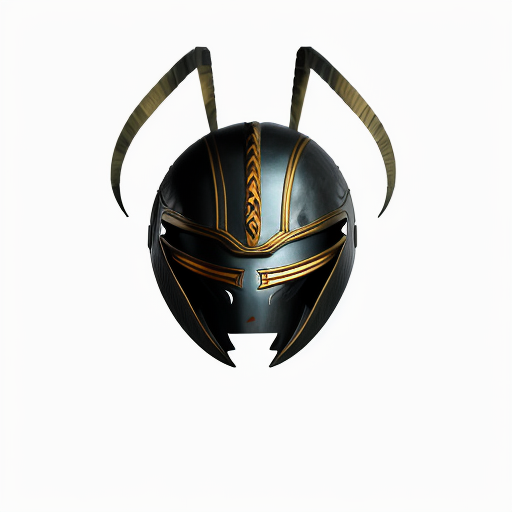

In [4]:
url = "https://stablediffusionapi.com/api/v5/controlnet"

payload = json.dumps({
  "key": SDAPI_KEY,
  "controlnet_model": "canny",
  "controlnet_type": "canny",
  "model_id": "juggernaut111",
  "auto_hint": "yes",
  "guess_mode": "no",
  "prompt": "a predator alien wearing a Roman Gladiator helmet with this shape",
  "negative_prompt": None,
  "init_image": "https://storage.googleapis.com/esov-sdapi-args-images/sp_512.jpg",
  # "init_image": "https://storage.googleapis.com/esov-sdapi-args-images/final_sp.png",
  # "control_image": "https://storage.googleapis.com/esov-sdapi-args-images/original_sp.jpg",
  # "mask_image": "https://storage.googleapis.com/esov-sdapi-args-images/original_sp.jpg",
  "width": "1024",
  "height": "1024",
  "samples": "1",
  "upscale": "yes",
  "scheduler": "UniPCMultistepScheduler",
  "num_inference_steps": "35",
  "safety_checker": "no",
  "enhance_prompt": "yes",
  "guidance_scale": 7.5,
  "strength": 0.55,
  "lora_model": None,
  "tomesd": "yes",
  "use_karras_sigmas": "yes",
  "vae": None,
  "lora_strength": None,
  "embeddings_model": None,
  "seed": None,
  "webhook": None,
  "track_id": None
})

headers = {
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

json_val = response.json()
print(json.dumps(json_val, indent=4))
req_status = json_val['status']
print(req_status)
if req_status != 'success' and req_status != 'processing':
    print("request failed")
else:
    output_url = None
    if 'fetch_result' in json_val:
        print("fetch_result")
        result_url = json_val['fetch_result']
        print(f"fetch_result url: {result_url}")
        payload_fr = json.dumps({
            "key": SDAPI_KEY
        })
        status = None
        image = None
        timeStart = time.time()
        while status != 'success':
            print("running")
            result_fr = requests.request("POST", result_url, headers=headers, data=payload_fr)
            json_result = result_fr.json()
            print(json.dumps(json_result, indent=4))
            status = json_result['status']
            print(status)
            timeEnd = time.time()
            if timeEnd - timeStart > 60:
                print("timeout")
                break
        if status == 'success':
            output_url = json_result['output'][0]
        
    elif 'output' in json_val and len(json_val['output']) > 0:
        print("output")
        output_url = json_val['output'][0]

    if output_url is None:
        print("no output url")
    else:
        attempts = 0
        while attempts < 5:
            try:
                print("getting output url")
                imageBytes = requests.get(output_url).content
                pilImage = Image.open(BytesIO(imageBytes))
                break
            except:
                print("error getting output url")
                attempts += 1
                time.sleep(0.1)
pilImage

In [5]:
pilImage.size

(512, 512)

success


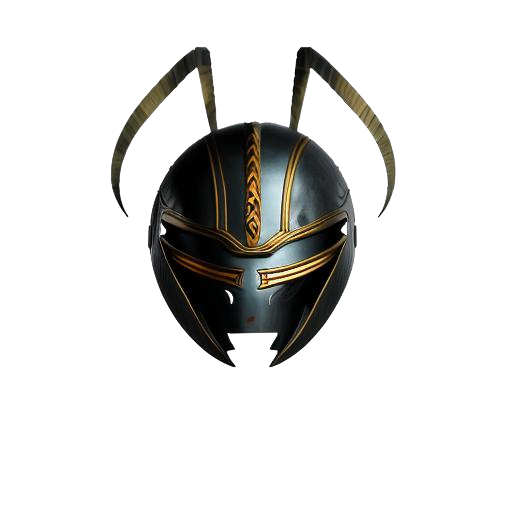

In [6]:
# pil image pilImage as bytes
image_file_object = io.BytesIO()
pilImage.save(image_file_object, format='JPEG')
image_file_object.seek(0)  # Go back to the start of the file object
image_bytes = image_file_object.read()  # Read the bytes from the file object
r = requests.post('https://clipdrop-api.co/remove-background/v1',
  files = {
    'image_file': ('car.jpg', image_bytes, 'image/jpeg'),
    },
  headers = { 'x-api-key': CLIPDROP_KEY}
)
if (r.ok):
    print("success")
    rembg_image = Image.open(io.BytesIO(r.content))
else:
  print(r.status_code, r.text) # e.g. 400 "Invalid image file"
rembg_image

In [7]:
urls = [
    "https://storage.googleapis.com/esov-sdapi-args-images/original_sp.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/final_sp.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l1_chin.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_george.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_luke.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_satoshi.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_spart.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_sun.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_will.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_01.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_02.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_03.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_04.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_05.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_06.jpg",
]

original_sp = ["https://storage.googleapis.com/esov-sdapi-args-images/original_sp.jpg"]
final_sp = ["https://storage.googleapis.com/esov-sdapi-args-images/final_sp.png"]
l1_chin = ["https://storage.googleapis.com/esov-sdapi-args-images/l1_chin.png"]
l3 = [
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_george.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_luke.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_satoshi.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_spart.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_sun.png",
    "https://storage.googleapis.com/esov-sdapi-args-images/l3_will.png",
]
l4_bg = [
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_01.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_02.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_03.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_04.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_05.jpg",
    "https://storage.googleapis.com/esov-sdapi-args-images/l4_bg_06.jpg",
]

all_arrays = [original_sp, final_sp, l1_chin, l3, l4_bg]
for arr in all_arrays:
    for i in range(len(arr)):
        url = arr[i]
        imageBytes = requests.get(url).content
        pilImage = Image.open(BytesIO(imageBytes))
        arr[i] = pilImage

In [8]:
print(f"original_sp img size {original_sp[0].size}")
print(f"final_sp img size {final_sp[0].size}")
print(f"l1_chin img size {l1_chin[0].size}")
print(f"l3 img size {l3[0].size}")
print(f"l4_bg img size {l4_bg[0].size}")

original_sp img size (800, 800)
final_sp img size (800, 800)
l1_chin img size (800, 800)
l3 img size (800, 800)
l4_bg img size (800, 800)


In [28]:
rembg_image_resized = rembg_image.resize((800, 800))
random_bg = l4_bg[random.randint(0, len(l4_bg) - 1)]
random_bottom = l3[random.randint(0, len(l3) - 1)]

In [ ]:
def add_outline(original_image):
    # Create a copy of the original image to work with
    outlined_image = original_image.copy()

    # Apply a contour filter to create an outline
    outline_image = outlined_image.filter(ImageFilter.CONTOUR)

    # Convert the outline image to have an alpha channel
    outline_image.putalpha(255)

    # Create a blank image to hold the final result
    final_image = Image.new("RGBA", original_image.size, (0, 0, 0, 0))

    # Composite the original image onto the final image
    final_image.paste(original_image, (0, 0), original_image)

    # Composite the outline image onto the final image
    final_image.paste(outline_image, (0, 0), outline_image)

    # Save or display the result
    final_image.show()

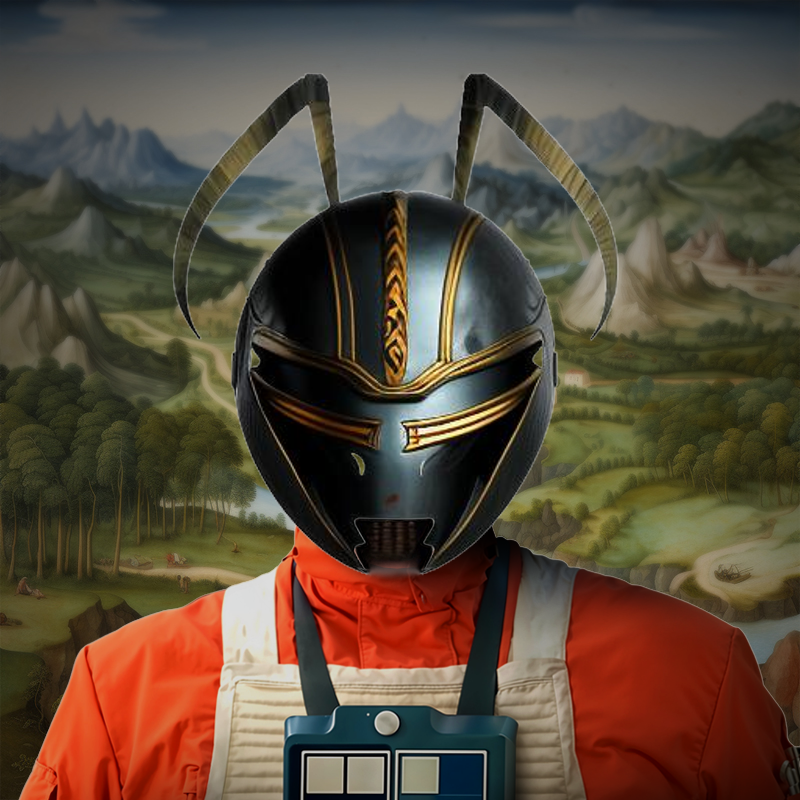

In [32]:
filteredImage = rembg_image_resized

base_image = Image.new('RGBA', random_bg.size, (0, 0, 0, 0))
base_image.paste(random_bg, (0, 0))
base_image.paste(random_bottom, (0, 0), random_bottom)
base_image.paste(rembg_image_resized, (0, 0), filteredImage)
base_image.paste(l1_chin[0], (0, 0), l1_chin[0])
base_image

In [ ]:
# Convert the base_image to a byte stream
byte_stream = BytesIO()
base_image.save(byte_stream, format='PNG')
byte_stream.seek(0)

# Initialize a GCS client
client = storage.Client()

# Create a bucket object for esov-sdapi-public-images
bucket = client.get_bucket('esov-sdapi-public-images')

# Create a blob in the bucket
blob = bucket.blob('base_image.png')

# Upload the byte stream to the blob
blob.upload_from_file(byte_stream, content_type='image/png')

# Print the public URL of the blob
print(blob.public_url)